# Pal 5 Tidal Stream Simulation

Simulates tidal disruption of Pal 5 for 3 orbits using the Fardal+15 particle-spray method (`create_mock_stream_fardal15`).

**Pipeline:**
1. Load Pal 5 parameters from the bundled GC catalogue
2. Build the MWPotential2014 host potential
3. Create a Plummer satellite potential
4. Run `create_mock_stream_fardal15` for 3 orbital periods
5. Display 6-D phase-space and convert to heliocentric (ICRS) observables
6. Plot stream in Galactocentric and ICRS frames

In [1]:
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import agama

from streamcutter.coordinate import get_observed_coords
from streamcutter.dynamics import GCParams
from streamcutter.stream_generator import (
    create_mock_stream_fardal15,
    create_initial_condition_fardal15,
)

# Agama unit system: 1 kpc, 1 km/s, 1 Msun
# The corresponding time unit is 1 kpc / (1 km/s) ≈ 0.9778 Gyr.
agama.setUnits(length=1, velocity=1, mass=1)

# Conversion factor: Myr → Agama time units
# 1 Agama TU ≈ 0.9778 Gyr  →  1 Myr = 1e-3 Gyr / 0.9778 (Gyr / Agama TU)
_GYR_PER_AGAMA_TU = 0.9778

## 1. Load Pal 5 parameters from the GC catalogue

In [2]:
gcp = GCParams()
matches = gcp.find_cluster("Pal 5")
if not matches:
    raise RuntimeError("Pal 5 not found in the GC catalogue.")
cluster_name = matches[0]
row = gcp.get_row(cluster_name)

print(f"Cluster: {cluster_name}")

# 6-D phase-space coordinates: extract numeric values in the correct units
posvel_sat = np.array([
    row["X_gc"][0].to_value(u.kpc),
    row["Y_gc"][0].to_value(u.kpc),
    row["Z_gc"][0].to_value(u.kpc),
    row["Vx_gc"][0].to_value(u.km/u.s),
    row["Vy_gc"][0].to_value(u.km/u.s),
    row["Vz_gc"][0].to_value(u.km/u.s),
])

mass_sat = row["Mass"][0].to_value(u.solMass)          # [Msun]
rhm_kpc  = row["rh,m"][0].to_value(u.pc) * 1e-3       # half-mass radius [pc → kpc]

# Orbital period in Agama time units
orbit_period_myr = row["orbit_period_max"][0].to_value(u.Myr)   # [Myr]
orbit_period     = orbit_period_myr * 1e-3 / _GYR_PER_AGAMA_TU  # [Agama TU]

print(f"  posvel       : {posvel_sat}")
print(f"  mass         : {mass_sat:.3e} Msun")
print(f"  rh,m         : {row['rh,m'][0].to_value(u.pc):.2f} pc")
print(f"  orbit period : {orbit_period_myr:.1f} Myr  ({orbit_period:.3f} Agama TU)")

Cluster: Pal_5
  posvel       : [   7.1     0.22   15.74  -49.28 -144.14  -10.2 ]
  mass         : 1.340e+04 Msun
  rh,m         : 27.63 pc
  orbit period : 410.8 Myr  (0.420 Agama TU)


## 2. Build the host potential (MWPotential2014)

In [3]:
# Path to MWPotential2014.ini — resolve relative to the repo root
# Works whether the notebook is run from the repo root or notebooks/current/
_REPO_ROOT = Path("__file__").resolve().parents[0]
for _p in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
    if (_p / "configs" / "MWPotential2014.ini").is_file():
        _REPO_ROOT = _p
        break
pot_ini  = str(_REPO_ROOT / "configs" / "MWPotential2014.ini")
pot_host = agama.Potential(pot_ini)

## 3. Satellite potential (Plummer sphere)

In [4]:
pot_sat = agama.Potential(type="Plummer", mass=mass_sat, scaleRadius=rhm_kpc)

## 4. Simulate tidal disruption for 3 orbits

In [5]:
n_orbits      = 3
time_total    = -n_orbits * orbit_period   # negative → integrate backward
num_particles = 1000
rng           = np.random.default_rng(seed=42)

print(
    f"Running create_mock_stream_fardal15 for {n_orbits} orbits "
    f"(time_total = {time_total:.3f} Agama TU, "
    f"{num_particles} particles) ..."
)

time_sat, orbit_sat, xv_stream, ic_stream = create_mock_stream_fardal15(
    create_initial_condition_fardal15,
    rng,
    time_total,
    num_particles,
    pot_host,
    posvel_sat,
    mass_sat,
    pot_sat=pot_sat,
)

print(f"Satellite orbit : {orbit_sat.shape[0]} steps")
print(f"Stream particles: {xv_stream.shape[0]}")

Running create_mock_stream_fardal15 for 3 orbits (time_total = -1.260 Agama TU, 1000 particles) ...
Satellite orbit : 500 steps
Stream particles: 1000


/cluster/home/salmanhiro/DESI/GC-tidal/src/streamcutter/stream_generator.py:62: FutureWarning: forceDeriv is deprecated, use Potential.eval(..., der=True) instead
  der = pot_host.forceDeriv(np.column_stack([x,y,z]))[1]
1000 orbits complete (10204 orbits/s)


## 5. Inspect 6-D phase-space of the stream

In [6]:
print("6-D phase-space of first 5 stream particles [kpc, km/s]:")
print(f"{'x':>10} {'y':>10} {'z':>10} {'vx':>10} {'vy':>10} {'vz':>10}")
for ps in xv_stream[:5]:
    print(" ".join(f"{v:>10.4f}" for v in ps))

6-D phase-space of first 5 stream particles [kpc, km/s]:
         x          y          z         vx         vy         vz
    7.8212     2.3923    15.8649   -37.3006  -141.5451    18.5657
    6.3323    -1.6615    15.2396   -59.3896  -143.6198   -36.9753
    8.0864     3.4001    15.7467   -32.2545  -139.5108    30.5497
    5.7670    -2.7687    14.8949   -65.1213  -140.7794   -52.6514
    7.5813     1.5167    15.9013   -41.9035  -142.7010     7.6194


## 6. Convert to heliocentric (ICRS) observables

In [7]:
ra, dec, vlos, pmra, pmde, dist = get_observed_coords(xv_stream)

print("Observed coords of first 5 stream particles:")
print(f"{'RA (deg)':>10} {'Dec (deg)':>10} {'dist (kpc)':>11} "
      f"{'vlos (km/s)':>12} {'pmRA (mas/yr)':>14} {'pmDec (mas/yr)':>15}")
for i in range(min(5, len(ra))):
    print(
        f"{ra[i]:>10.4f} {dec[i]:>10.4f} {dist[i]:>11.4f} "
        f"{vlos[i]:>12.4f} {pmra[i]:>14.4f} {pmde[i]:>15.4f}"
    )

Observed coords of first 5 stream particles:
  RA (deg)  Dec (deg)  dist (kpc)  vlos (km/s)  pmRA (mas/yr)  pmDec (mas/yr)
  233.3374     3.3885     22.6041     -68.8213        -2.6730         -2.3929
  225.0475    -3.4290     21.0547     -51.2630        -2.7939         -2.8041
  235.5076     4.7892     22.8380     -73.7024        -2.6586         -2.3109
  222.5317    -5.5076     20.5380     -44.4405        -2.8372         -2.9187
  231.5061     2.0850     22.3849     -64.8687        -2.6853         -2.4642


## 7. Plot: Galactocentric + ICRS projections

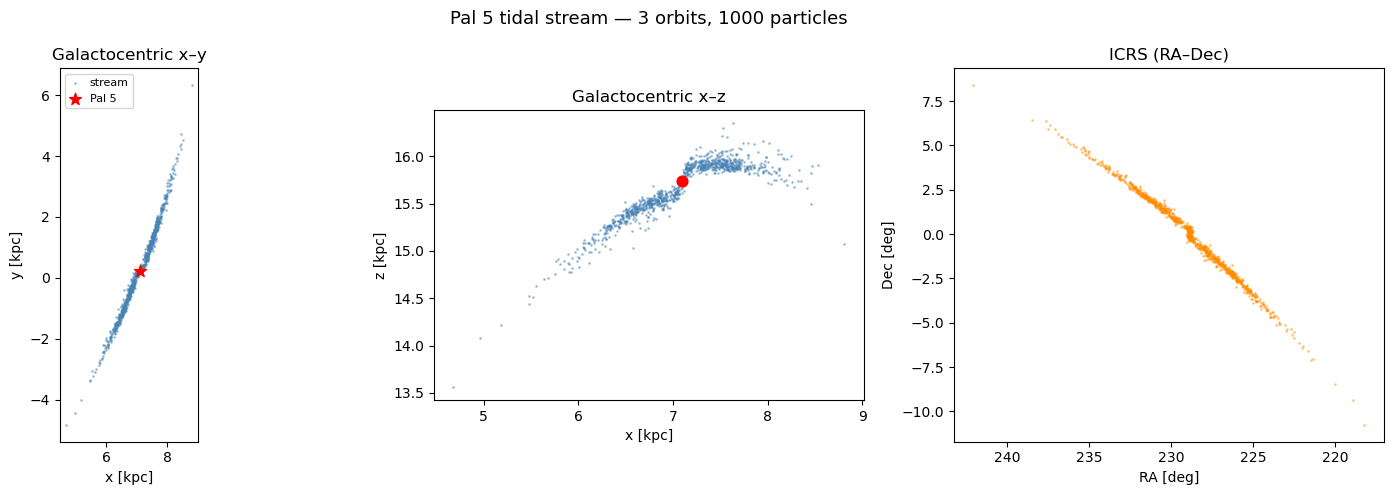

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Pal 5 tidal stream — {n_orbits} orbits, {num_particles} particles",
             fontsize=13)

# --- Galactocentric x-y ---
ax = axes[0]
ax.scatter(xv_stream[:, 0], xv_stream[:, 1],
           s=1, alpha=0.4, color="steelblue", label="stream")
ax.scatter(posvel_sat[0], posvel_sat[1],
           s=80, color="red", marker="*", zorder=5, label="Pal 5")
ax.set_xlabel("x [kpc]")
ax.set_ylabel("y [kpc]")
ax.set_title("Galactocentric x–y")
ax.legend(fontsize=8, scatterpoints=1, handlelength=1)
ax.set_aspect("equal")

# --- Galactocentric x-z ---
ax = axes[1]
ax.scatter(xv_stream[:, 0], xv_stream[:, 2],
           s=1, alpha=0.4, color="steelblue")
ax.scatter(posvel_sat[0], posvel_sat[2],
           s=60, color="red", zorder=5)
ax.set_xlabel("x [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_title("Galactocentric x–z")
ax.set_aspect("equal")

# --- ICRS RA-Dec ---
ax = axes[2]
ax.scatter(ra, dec, s=1, alpha=0.4, color="darkorange")
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.set_title("ICRS (RA–Dec)")
ax.invert_xaxis()   # astronomical convention: RA increases to the left

fig.tight_layout()
plt.show()